In [401]:
import os
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import seaborn as sns



In [662]:
W = 0.9

import pandas as pd
anime = pd.read_csv('anime.csv')
rating = pd.read_csv('rating.csv')
#remouve nan values
anime = anime.dropna()
rating = rating.dropna()


rating['user_id'] = rating['user_id'].astype(str)
rating['anime_id'] = rating['anime_id'].astype(str)
#changing the type of anime id to string 
anime["anime_id"] = anime["anime_id"].astype(str)

unique_user_ids = list(rating.user_id.unique())
unique_anime_ids = list(anime.anime_id.unique())
unique_genres = list(anime.genre.unique())
unique_types = list(anime.type.unique())
unique_ratings = list(rating.rating.unique())

##normalising the ratings of each user to be between -1 and 1 by subtracting the mean of the ratings of each user and removing the -1
rating['rating'] = rating['rating'].astype(float)
#removing -1 ratings
#ploting the distribution of the ratings with a box plot




rating = rating[rating['rating']!=-1]

#creating a new column for the binary ratings


rating['normalized_rating_1'] = rating.groupby('user_id')['rating'].transform(lambda x: (x - x.mean()))

rating['normalized_rating_2'] = rating.groupby('user_id')['rating'].transform(lambda x: (x - x.mean())/(x.max()-x.min()))
rating['normalized_rating_3'] = rating.groupby('user_id')['rating'].transform(lambda x: (x - x.mean())/(x.std()))


rating['binary_rating'] = rating['rating'].apply(lambda x: 1 if x>=0 else 0)

#renanaming the column rating to anime_rating

anime = anime.rename(columns={'rating':'anime_rating'})
#calculating the popularity of each anime by deviding the members by the top 90 percentile of the members

#anime['popularity'] = anime['members']/anime['members'].quantile(0.95)


anime['popularity'] = anime['members']/anime['members'].max()



#adding an iteraction factor beween the rating and the popularity of the anime
anime['anime_rating_weighted'] = anime['popularity']*anime['anime_rating']*W + (1-W)*anime['anime_rating']



#remouving NAN values
rating = rating.dropna()


In [577]:
rating

,user_id,anime_id,rating,normalized_rating_1,normalized_rating_2,normalized_rating_3,binary_rating
156,3,20,8.0,0.434783,0.062112,0.280517,1
157,3,154,6.0,-1.565217,-0.223602,-1.009861,1
158,3,170,9.0,1.434783,0.204969,0.925706,1
159,3,199,10.0,2.434783,0.347826,1.570895,1
160,3,225,9.0,1.434783,0.204969,0.925706,1
...,...,...,...,...,...,...,...
7813730,73515,13659,8.0,-0.547486,-0.109497,-0.481274,1
7813731,73515,14345,7.0,-1.547486,-0.309497,-1.360336,1
7813732,73515,16512,7.0,-1.547486,-0.309497,-1.360336,1
7813733,73515,17187,9.0,0.452514,0.090503,0.397788,1


In [641]:
anime.head(20)

,anime_id,name,genre,type,episodes,anime_rating,members,popularity,anime_rating_weighted
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,0.197876,8.618410
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,0.782771,9.058846
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,0.112694,8.429242
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,0.664327,8.862187
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,0.149190,8.380658
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351,0.092070,8.319244
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855,0.420010,8.600469
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679,0.079572,8.271490
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534,0.071538,8.255100
9,15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109,0.079996,8.271876


In [642]:
#printing the top 10 most popular animes
print(anime.sort_values(by='members', ascending=False).head(20))

    anime_id                                name  \
40      1535                          Death Note   
86     16498                  Shingeki no Kyojin   
804    11757                    Sword Art Online   
1       5114    Fullmetal Alchemist: Brotherhood   
159     6547                        Angel Beats!   
19      1575     Code Geass: Hangyaku no Lelouch   
841       20                              Naruto   
3       9253                         Steins;Gate   
445    10620                    Mirai Nikki (TV)   
131     4224                           Toradora!   
582      269                              Bleach   
760      226                          Elfen Lied   
449    22319                         Tokyo Ghoul   
118    19815                     No Game No Life   
200      121                 Fullmetal Alchemist   
288     6702                          Fairy Tail   
643     9919                      Ao no Exorcist   
440     3588                          Soul Eater   
13      2904

<Axes: xlabel='anime_rating_weighted'>

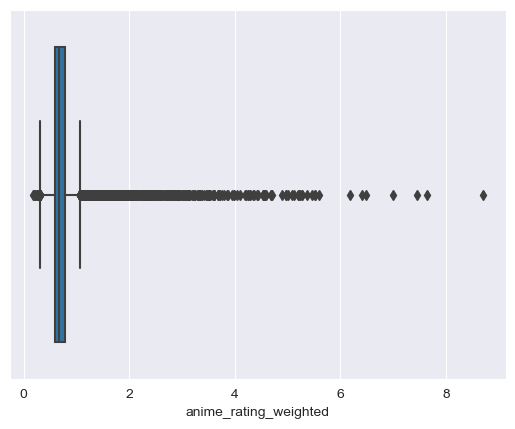

In [663]:
#distribution of binary ratings using a histogram

sns.boxplot(x=anime['anime_rating_weighted'])

<Axes: xlabel='normalized_rating_2', ylabel='Count'>

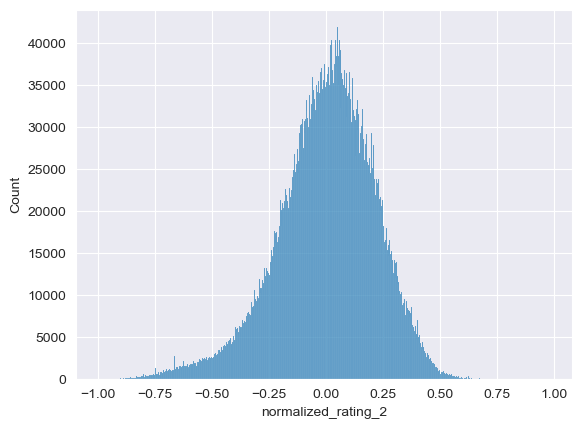

In [406]:
sns.histplot(x=rating['normalized_rating_2'])

<Axes: xlabel='normalized_rating_3', ylabel='Count'>

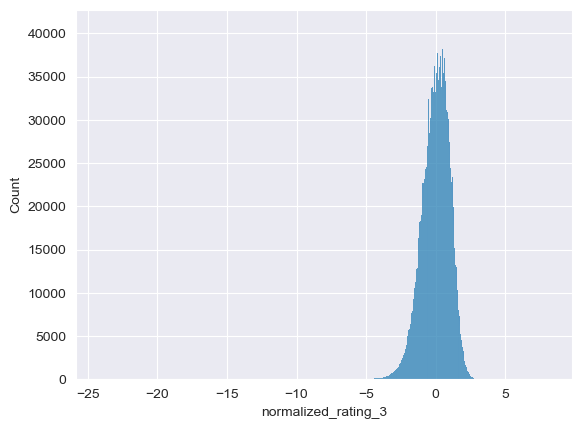

In [407]:
sns.histplot(x=rating['normalized_rating_3'])

<Axes: xlabel='anime_rating'>

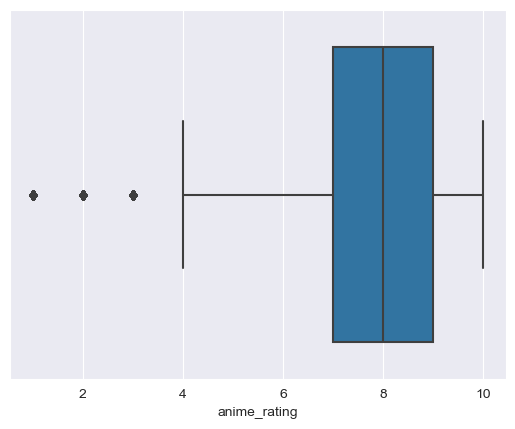

In [286]:
#ploting the distribution of the ratings with a box plot
import seaborn as sns
sns.boxplot(x=rating['anime_rating'])



In [664]:
unique_user_ids = np.unique(unique_user_ids)
unique_anime_ids = np.unique(unique_anime_ids)
unique_genres = np.unique(unique_genres)
unique_types = np.unique(unique_types)


In [665]:
#preaparing the data for the model
columns = ['anime_id','genre',"anime_rating","popularity","anime_rating_weighted"]

data = rating.merge(anime[columns], on='anime_id')
#dropping the columns that are not needed
print(data)


        user_id anime_id  rating  normalized_rating_1  normalized_rating_2  \
0             3       20     8.0             0.434783             0.062112   
1             5       20     6.0             1.644880             0.182764   
2            21       20     8.0             0.377778             0.047222   
3            28       20     9.0            -0.454545            -0.454545   
4            34       20     9.0             0.285714             0.095238   
...         ...      ...     ...                  ...                  ...   
6304671   69964    23585     7.0            -0.891859            -0.178372   
6304672   69964    33659     6.0            -1.891859            -0.378372   
6304673   72800    30738     4.0            -1.930159            -0.241270   
6304674   73135     8723     5.0            -0.710953            -0.078995   
6304675   73188     8749     6.0            -0.998418            -0.110935   

         normalized_rating_3  binary_rating  \
0               

In [666]:

ratings = tf.data.Dataset.from_tensor_slices(dict(rating))
data = tf.data.Dataset.from_tensor_slices(dict(data))

In [667]:
tf.random.set_seed(42)
shuffled = data.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

In [693]:
class RankingModel(tf.keras.Model):

  def __init__(self,binary=False):
    super().__init__()
    self.binary = binary
    embedding_dimension = 32

    # Compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for movies.
    self.anime_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_anime_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_anime_ids) + 1, embedding_dimension)
    ])
    self.genre_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_genres, mask_token=None),
      tf.keras.layers.Embedding(len(unique_genres) + 1, embedding_dimension)
    ])
    """self.type_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_types, mask_token=None),
      tf.keras.layers.Embedding(len(unique_types) + 1, embedding_dimension)
    ])"""

    self.item_importance = tf.keras.Sequential([

        tf.keras.layers.Dense(32, activation="linear"),
      
      
    ])
    """# Learn multiple dense layers.
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(64, activation="relu"),
      # Make rating predictions in the final layer.
      tf.keras.layers.Dense(1)"""
    # Compute predictions.
    if binary:
      self.ratings = tf.keras.Sequential([
       
        tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation="sigmoid", kernel_regularizer=tf.keras.regularizers.l2(0.01))
      ])
    else:
      self.ratings = tf.keras.Sequential([
        
        tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01))
      ])
    
      
  def item_embedding(self, anime_id, genre, type):
    anime_embedding = self.anime_embeddings(anime_id)
    genre_embedding = self.genre_embeddings(genre)
    type_embedding = self.type_embeddings(type)
    return (anime_embedding + genre_embedding + type_embedding) / 3.0

  def call(self, inputs):

    user_id, anime_id, genre,rating, popularity = inputs
    
    """user_id=tf.convert_to_tensor(user_id)
    anime_id=tf.convert_to_tensor(anime_id)"""
    
    user_embedding = self.user_embeddings(user_id)
    anime_embedding = self.anime_embeddings(anime_id)
    
    #converting the rating to a tensor
    anime_rating = tf.convert_to_tensor(rating, dtype=tf.float32)
    anime_rating = tf.expand_dims(anime_rating, axis=1)
    
    anime_popularity = tf.convert_to_tensor(popularity, dtype=tf.float32)
    anime_popularity = tf.expand_dims(anime_popularity, axis=1)
    
    genre_embedding = self.genre_embeddings(genre)
    
    #type_embedding = self.type_embeddings(type)

  
    
    item = tf.concat([anime_embedding, genre_embedding], axis=1)
    item = self.item_importance(item)
    
    return self.ratings(tf.concat([user_embedding,anime_embedding, genre_embedding,item,anime_popularity], axis=1))

In [694]:
task = tfrs.tasks.Ranking(
  loss = tf.keras.losses.MeanSquaredError(),
  metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

task_binary = tfrs.tasks.Ranking(
  loss = tf.keras.losses.BinaryCrossentropy(),
  metrics=[tf.keras.metrics.BinaryAccuracy()]
)


In [695]:
class AnimeModel(tfrs.models.Model):

  def __init__(self,binary=False):
    super().__init__()
    self.ranking_model: tf.keras.Model = RankingModel(binary)
    self.binary = binary
    if binary:
      self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss = tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy()]
      )
    else:
      self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss = tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model(
        (features["user_id"], features["anime_id"], features["genre"], features["anime_rating"],features["anime_rating_weighted"]))

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    """labels = features.pop("rating")

    rating_predictions = self(features)
    """
    features = features.copy()  # Make a shallow copy of features
    if self.binary:
      labels = features.pop("binary_rating")
    else:
      labels = features.pop("rating")
        
    
    rating_predictions = self(features)

    # The task computes the loss and the metrics.
  
    return self.task(labels=labels, predictions=rating_predictions)

    

In [696]:
model = AnimeModel(binary=False)



In [697]:
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1,clipnorm=0.001))

cached_train = train.shuffle(10_000).batch(8192).cache()
cached_test = test.batch(4096).cache()


In [698]:
two_layer_history = model.fit(cached_train, epochs=700,validation_data=cached_test)

Epoch 1/700


/Users/yassine/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'anime_model_53', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - loss: 61.6727 - regularization_loss: 2.1629 - root_mean_squared_error: 7.8483 - total_loss: 63.8356 - val_loss: 62.1852 - val_regularization_loss: 2.1630 - val_root_mean_squared_error: 7.8607 - val_total_loss: 64.3481
Epoch 2/700
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 60.7229 - regularization_loss: 2.1630 - root_mean_squared_error: 7.7903 - total_loss: 62.8859 - val_loss: 61.2801 - val_regularization_loss: 2.1630 - val_root_mean_squared_error: 7.8024 - val_total_loss: 63.4431
Epoch 3/700
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 59.7821 - regularization_loss: 2.1630 - root_mean_squared_error: 7.7328 - total_loss: 61.9451 - val_loss: 60.3833 - val_regularization_loss: 2.1630 - val_root_mean_squared_error: 7.7441 - val_total_loss: 62.5463
Epoch 4/700
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 58.8494 - regularization_loss: 2.1630 - root_mean_squared_error: 7.6754 - total_loss: 61.0124 - val_loss: 59.4931 - val_regularization_

In [699]:

model.evaluate(cached_test, return_dict=True)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8285 - regularization_loss: 1.7095 - root_mean_squared_error: 1.5877 - total_loss: 4.5380


{'loss': 3.261929750442505,
 'regularization_loss': 1.709537148475647,
 'root_mean_squared_error': 1.6520521640777588,
 'total_loss': 4.971467018127441}

In [700]:

accuracy = two_layer_history.history
loss = accuracy['loss']

val_loss = accuracy['val_loss']


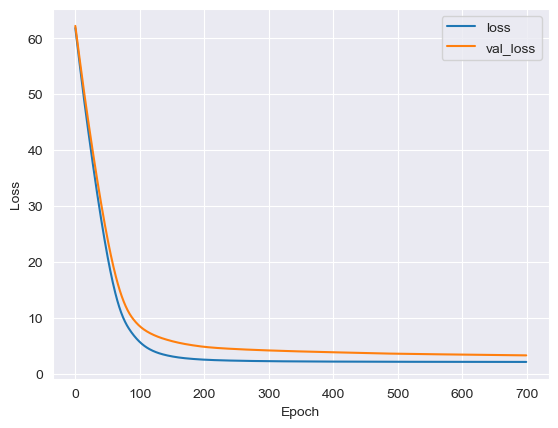

In [701]:
#plotting the loss
import matplotlib.pyplot as plt
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#plotting other metrics 


In [702]:
from sklearn.metrics.pairwise import cosine_similarity
#getting the top k movies for a user using similarity model of the embeddings
# Get the embeddings of the animes for the first user in the dataset
user_id = "3"
print(user_id)
user_id = tf.convert_to_tensor([user_id])
anime_embeddings = model.ranking_model.anime_embeddings(anime['anime_id']) 
user_embedding = model.ranking_model.user_embeddings(user_id)  

# Compute the similarity between user and anime embeddings using cosine similarity 

similarity = cosine_similarity(user_embedding, anime_embeddings)
print(similarity)
similarity = similarity[0]


#similarity = tf.reduce_sum(user_embeddings * anime_embeddings, axis=1)
# Get the top 10 most similar animes

top_animes = pd.DataFrame({
    'anime_id': anime['anime_id'],
    'similarity': similarity
})
top_animes = top_animes.sort_values(by='similarity', ascending=False).head(10)
top_animes = top_animes.merge(anime, on='anime_id')

print(user_id)
print(top_animes)

#cheking how many of the top animes are in the users ratings
top_animes = top_animes.merge(rating[rating["user_id"]=="3"], on='anime_id')
print(top_animes[['anime_id', 'name']]) 

#printing the top 10 users that are similar to the user
unique_user_ids = unique_user_ids
user_embeddings = model.ranking_model.user_embeddings(unique_user_ids)

similarity = cosine_similarity(user_embedding, user_embeddings)


top_users = pd.DataFrame({
    'user_id': unique_user_ids,
    'similarity': similarity[0]
})
top_users = top_users.sort_values(by='similarity', ascending=False).head(2)
print("#############")
print(top_users)
#printing the second uer that is similar to the user

#in order to verify the results we can check the ratings of the second top users and see if they are similar to the user
top_users_2 = top_users.merge(rating[rating["user_id"]==top_users.iloc[1]['user_id']], on='user_id')
print(top_users_2[['user_id', 'rating','anime_id']])
top_users_3 = top_users.merge(rating[rating["user_id"]==top_users.iloc[0]['user_id']], on='user_id')
#intersectting woth top_users_2 and top_users_3 using the anime_id
top_users_4 = top_users_3.merge(top_users_2, on='anime_id')

print(top_users_4)

3
[[ 0.12019101  0.09873442 -0.16524285 ... -0.05648056  0.01485857
   0.12077903]]
tf.Tensor([b'3'], shape=(1,), dtype=string)
  anime_id  similarity                                               name  \
0    21129    0.617906                          Youtai Nuhai Zai Shanghai   
1      411    0.607839                                        Gun x Sword   
2     8460    0.565183                                        Mirai Nikki   
3    13663    0.557980                                To LOVE-Ru Darkness   
4     5332    0.557026                    Toshokan Sensou: Koi no Shougai   
5    31102    0.553949  Taiko no Tatsujin: 15 Shuunenkinen Short Anima...   
6    13693    0.547617                         Ippatsu Hicchuu!! Devander   
7     9691    0.543930                                Kyomu Senshi Miroku   
8    30394    0.542526                                              Teddy   
9     1157    0.542471                           Final Fantasy: Unlimited   

                        

In [703]:
import tensorflow as tf
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Assuming `anime` is your DataFrame with anime data
# `model` is your trained model

anime_id = "138"
anime_id_tensor = tf.convert_to_tensor([anime_id])  # Ensure dtype is correct
anime_genre_tensor = tf.convert_to_tensor([anime[anime['anime_id'] == anime_id]['genre'].values[0]])
# Retrieve embeddings
anime_embeddings = model.ranking_model.anime_embeddings(anime['anime_id'])
anime_embedding = model.ranking_model.anime_embeddings(anime_id_tensor)

genre_embeddings = model.ranking_model.genre_embeddings(anime['genre'])
genre_embedding = model.ranking_model.genre_embeddings(anime_genre_tensor)

# Print the name of the anime
print("Anime:", anime[anime['anime_id'] == anime_id]['name'])

# Compute cosine similarity
similarity = cosine_similarity(anime_embedding, anime_embeddings)
similarity = similarity[0]

genre_similarity = cosine_similarity(genre_embedding, genre_embeddings)
genre_similarity = genre_similarity[0]

# Debug: Check shapes and values
print("Anime Embedding Shape:", anime_embedding.shape)
print("Anime Embeddings Shape:", anime_embeddings.shape)
print("Genre Embedding Shape:", genre_embedding.shape)
print("Genre Embeddings Shape:", genre_embeddings.shape)

print("Similarity Scores:", similarity[:10])  # Print first 10 similarity scores
print("Genre Similarity Scores:", genre_similarity[:10])  # Print first 10 genre similarity scores

# Get the top 10 most similar animes
top_anime_genre = pd.DataFrame({
    'anime_id': anime['anime_id'],
    'similarity': genre_similarity
})

top_animes = pd.DataFrame({
    'anime_id': anime['anime_id'],
    'similarity': similarity
})

top_animes = top_animes.sort_values(by='similarity', ascending=False).head(10)
top_animes = top_animes.merge(anime, on='anime_id')

top_anime_genre = top_anime_genre.sort_values(by='similarity', ascending=False).head(10)
top_anime_genre = top_anime_genre.merge(anime, on='anime_id')

print("Top Animes based on Embeddings:")
print(top_animes[['anime_id', 'name', 'similarity', 'genre', 'type']])
print("Top Animes based on Genre Similarity:")
print(top_anime_genre[['anime_id', 'name', 'similarity', 'genre', 'type']])
#calculate the similarity of genre_embedding

print(cosine_similarity(genre_embedding, genre_embedding))

Anime: 202    Hunter x Hunter: Greed Island
Name: name, dtype: object
Anime Embedding Shape: (1, 32)
Anime Embeddings Shape: (12017, 32)
Genre Embedding Shape: (1, 32)
Genre Embeddings Shape: (12017, 32)
Similarity Scores: [-0.07568601 -0.22632492  0.07999416  0.14420718 -0.16822797  0.08900906
 -0.23329288 -0.09082665  0.11047709 -0.31850222]
Genre Similarity Scores: [-0.4182784  -0.21158418 -0.15218964 -0.16836186 -0.15218964 -0.12749833
  1.          0.14742316 -0.15218964 -0.15218964]
Top Animes based on Embeddings:
  anime_id                                               name  similarity  \
0      138                      Hunter x Hunter: Greed Island    1.000000   
1    10219  Oniichan no Koto nanka Zenzen Suki ja Nai n da...    0.649177   
2     6747                          Dance in the Vampire Bund    0.628100   
3      881                                    Green Green OVA    0.577287   
4     6299                  Maria-sama ga Miteru 4th Specials    0.570151   
5    31933  

In [704]:
#dong the same but we concatinate the genre and type embeddings to the anime embeddings
anime_id = "138"
anime_id = tf.convert_to_tensor([anime_id])
anime_embeddings = model.ranking_model.anime_embeddings(anime['anime_id'])
anime_embedding = model.ranking_model.anime_embeddings(anime_id)

anime_genre_tensor = tf.convert_to_tensor([anime[anime['anime_id'] == anime_id]['genre'].values[0]])

genre_embeddings = model.ranking_model.genre_embeddings(anime['genre'])
genre_embedding = model.ranking_model.genre_embeddings(anime_genre_tensor)


#concatinating the embeddings
"""anime_embedding = tf.concat([anime_embedding*2.0,genre_embedding], axis=1)
anime_embeddings = tf.concat([anime_embeddings*2.0,genre_embeddings], axis=1)"""

item = tf.concat([anime_embedding, genre_embedding], axis=1)
item = model.ranking_model.item_importance(item)

items = tf.concat([anime_embeddings, genre_embeddings], axis=1)
items = model.ranking_model.item_importance(items)

# Compute the similarity between user and anime embeddings
"""
similarity = tf.reduce_sum(anime_embedding * anime_embeddings, axis=1)
similarity_based_on_item = tf.reduce_sum(item * items, axis=1)  """

#calulating the similatiry based on cosine similarity
similarity = cosine_similarity(anime_embedding, anime_embeddings)
similarity = similarity[0]

similarity_based_on_item = cosine_similarity(item, items)
similarity_based_on_item = similarity_based_on_item[0]



# Get the top 10 most similar animes

top_items = pd.DataFrame({
    'anime_id': anime['anime_id'],
    'similarity': similarity_based_on_item
})

top_animes = pd.DataFrame({
    'anime_id': anime['anime_id'],
    'similarity': similarity
})

top_animes = top_animes.sort_values(by='similarity', ascending=False).head(10)
top_animes = top_animes.merge(anime, on='anime_id')

top_items = top_items.sort_values(by='similarity', ascending=False).head(10)
top_items = top_items.merge(anime, on='anime_id')

#print(top_animes[['anime_id', 'name','similarity', 'genre' , 'type' ]])

print(top_items[['anime_id', 'name','similarity', 'genre' , 'type' ]])


  anime_id                                               name  similarity  \
0      138                      Hunter x Hunter: Greed Island    1.000000   
1    23627      Aoki Hagane no Arpeggio: Ars Nova - Kirikumas    0.988508   
2    32026                               Osomatsu-san Special    0.987285   
3    12863                      Pretty Rhythm: Dear My Future    0.986160   
4     1979                             Tobira wo Akete (1995)    0.985933   
5    29821                                        Channel 5.5    0.985795   
6    19977                     The Impression of First Gundam    0.985064   
7    28573  Somei-ka no Hi no Youjin: Bouka no Tebiki Kate...    0.985048   
8    25667                      Boy Meets Harem The Animation    0.984906   
9    10590                                            Reunion    0.984605   

                                     genre     type  
0  Action, Adventure, Shounen, Super Power      OVA  
1                           Comedy, Parody  

In [705]:
from sklearn.metrics.pairwise import cosine_similarity
#getting the top k movies for a user using similarity model of the embeddings
# Get the embeddings of the animes for the first user in the dataset
user_id = "3"
print(user_id)
user_id = tf.convert_to_tensor([user_id])
anime_embeddings = model.ranking_model.anime_embeddings(anime['anime_id']) 
user_embedding = model.ranking_model.user_embeddings(user_id)  
genre_embeddings = model.ranking_model.genre_embeddings(anime['genre'])

items = tf.concat([anime_embeddings, genre_embeddings], axis=1)
items = model.ranking_model.item_importance(items)

# Compute the similarity between user and anime embeddings using cosine similarity 

similarity = cosine_similarity(user_embedding, items)
print(similarity)
similarity = similarity[0]

#printing the top 10 most similar animes to the user with the ratings if exits 

top_anime = pd.DataFrame({
    'anime_id': anime['anime_id'],
    'similarity': similarity
})

top_anime = top_anime.sort_values(by='similarity', ascending=False).head(100)
#merging the top animes with the ratings of the user with constraint that the user id is 3

top_anime = top_anime.merge(rating[rating['user_id']=="3"], on='anime_id')

print(top_anime)

3
[[0.00400214 0.03590659 0.0576449  ... 0.04153197 0.04140284 0.04840111]]
  anime_id  similarity user_id  rating  normalized_rating_1  \
0    28121    0.155878       3     9.0             1.434783   

   normalized_rating_2  normalized_rating_3  binary_rating  
0             0.204969             0.925706              1  


In [706]:

# User ID
user_id = "3"

# Adding user id to all the animes
anime['user_id'] = user_id

# Convert DataFrame to TensorFlow dataset
anime_features = tf.data.Dataset.from_tensor_slices(dict(anime))
anime_features = anime_features.batch(1)

# Initialize your model (ensure the model is trained before prediction)

# Predict ratings for all animes
predictions = []
for batch in anime_features:
    user_id_tensor = batch['user_id']
    anime_id_tensor = batch['anime_id']
    genre_tensor = batch['genre']
    rating_tensor = batch['anime_rating']
    popularity = batch['popularity']
    
    rating_prediction = model({
        "user_id": user_id_tensor,
        "anime_id": anime_id_tensor,
        "genre": genre_tensor,
        "anime_rating": rating_tensor,
        "anime_rating_weighted": popularity
        
    })
    print(rating_prediction.numpy()[0][0])
    predictions.append({
        'anime_id': anime_id_tensor.numpy()[0].decode('utf-8'), 
        'predicted_rating': rating_prediction.numpy()[0][0]
    })

# Create a new DataFrame with the predictions
predictions_df = pd.DataFrame(predictions)

# Print the DataFrame with anime IDs and their predicted ratings
print(predictions_df)

3.8345218
4.113906
3.8119256
3.95968
3.8754687
6.0839615
4.0053596
3.7914507
3.8759892
3.8188715
4.1008587
3.9189484
3.8982596
4.032979
6.1408663
7.673424
3.936706
3.9470773
3.8079696
4.1220365
3.8162034
3.9122922
4.0270376
4.095438
3.9725442
3.7360535
3.9598258
3.8263083
3.9870439
3.9940913
3.9076006
3.8289328
3.7852929
3.8895612
3.8400025
3.9888027
3.9837778
3.907006
3.9579382
4.0062666
6.299033
3.8272243
3.9318182
6.1586256
3.8359735
3.7479224
3.6712363
3.7482014
3.8227477
4.0469975
3.9122784
3.8063936
3.8477902
3.9253101
3.9888537
3.886301
3.8468852
3.9843254
3.7996845
3.858708
3.9132924
3.9952924
3.892881
3.7925868
3.8359365
3.852332
3.9304328
3.9309416
3.914031
3.891647
3.9962883
3.9157484
3.9332001
3.881132
3.9321525
3.80226
5.6377897
4.0014715
3.7871687
7.995653
3.9222286
3.9150863
3.8253677
3.8728387
4.06478
3.9481742
4.208807
4.0346346
3.8982775
3.7830696
3.9358194
4.0939445
3.8893337
3.7570305
4.0142727
3.8158998
3.9921923
4.023884
4.0283194
3.8074532
3.808124
3.781406
3.903

2024-05-20 03:40:39.576349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [707]:
#print top 10  animes from the predictions and merging them with the anime data to see the names of the animes and the genre 


top_anime = predictions_df.sort_values(by='predicted_rating', ascending=False).head(10)


top_anime = top_anime.merge(anime, on='anime_id')

print(top_anime)

  anime_id  predicted_rating  \
0      170          7.995653   
1      199          7.673424   
2     1943          7.376678   
3     1689          7.340856   
4      813          7.314801   
5      430          7.261928   
6      552          7.256190   
7      154          7.255230   
8      341          7.147161   
9     1526          7.039374   

                                                name  \
0                                          Slam Dunk   
1                      Sen to Chihiro no Kamikakushi   
2                                            Paprika   
3                              Byousoku 5 Centimeter   
4                                      Dragon Ball Z   
5    Fullmetal Alchemist: The Conqueror of Shamballa   
6                                  Digimon Adventure   
7                                        Shaman King   
8                            Spiral: Suiri no Kizuna   
9  Pokemon Advanced Generation: Mew to Hadou no Y...   

                              

In [ ]:
#using 

12018
73516


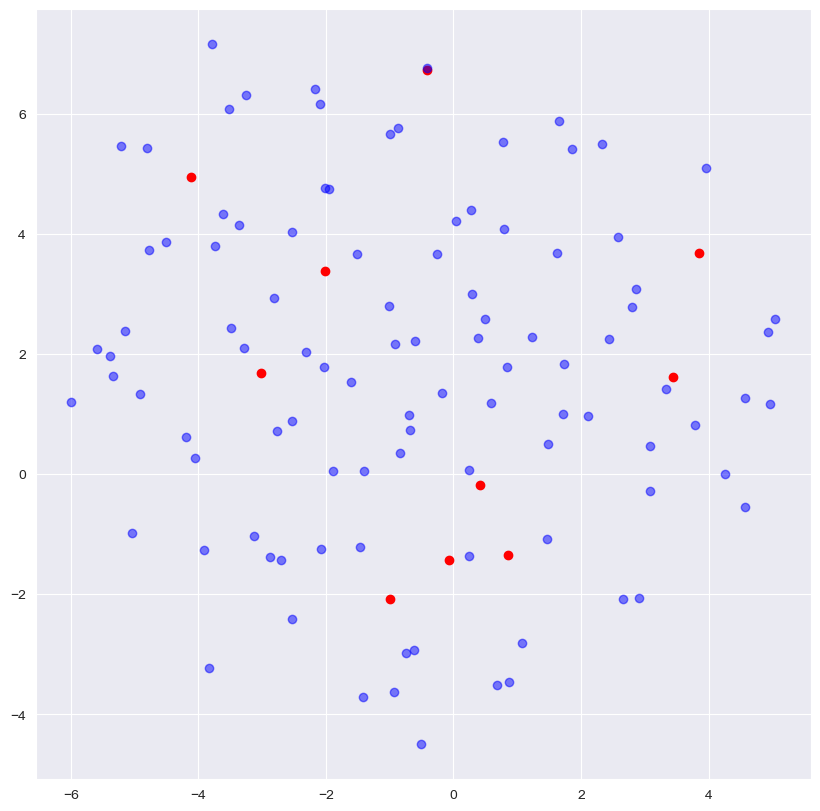

In [543]:
#using tsne to visualise the embeddings
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Extract embeddings
user_embeddings = model.ranking_model.user_embeddings.get_weights()[0]
anime_embeddings = model.ranking_model.anime_embeddings.get_weights()[0]
print(len(anime_embeddings))
print(len(user_embeddings))
# Take the first 1000 most popular anime
popular_anime = anime['anime_id'].value_counts().index[:100]
#popular_anime_embeddings = anime_embeddings[popular_anime]

#popular_anime_embeddings = anime_embeddings[:100]
users = user_embeddings[:10]

popular_anime_embeddings = model.ranking_model.anime_embeddings(popular_anime)
#users = model.ranking_model.user_embeddings(users)

data = np.concatenate([users, popular_anime_embeddings], axis=0)
# Reduce dimensionality to 2D
tsne = TSNE()
tsne_transformed = tsne.fit_transform(data)

# Separate user and anime embeddings
user_tsne = tsne_transformed[:len(users)]
anime_tsne = tsne_transformed[len(users):]

# Plot user and anime embeddings
plt.figure(figsize=(10, 10))
plt.scatter(user_tsne[:, 0], user_tsne[:, 1], color='red')
plt.scatter(anime_tsne[:, 0], anime_tsne[:, 1], color='blue', alpha=0.5)
plt.show()


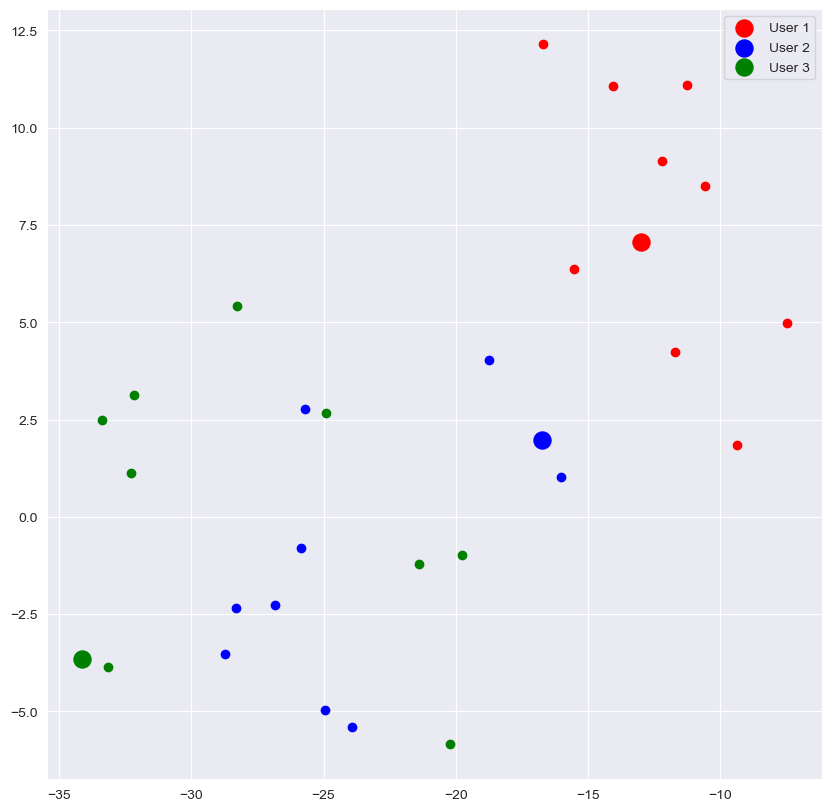

In [549]:
def extract_embedding(user_id,model):
    user_id = tf.convert_to_tensor([user_id])
    user_embedding = model.ranking_model.user_embeddings(user_id)
    return user_embedding

def top_k_similar_animes(user_id,model,k=10):
    user_id = tf.convert_to_tensor([user_id])
    anime_embeddings = model.ranking_model.anime_embeddings(anime['anime_id'])
    user_embedding = model.ranking_model.user_embeddings(user_id)  
    genre_embeddings = model.ranking_model.genre_embeddings(anime['genre'])

    items = tf.concat([anime_embeddings, genre_embeddings], axis=1)
    items = model.ranking_model.item_importance(items)

    # Compute the similarity between user and anime embeddings using cosine similarity 
    
    #extracting the top 10 anime embeddigs
    similarity = cosine_similarity(user_embedding, items)
    similarity = similarity[0]
    
    top_anime = pd.DataFrame({
        'anime_id': anime['anime_id'],
        'similarity': similarity
        
    })
    
    top_anime = top_anime.sort_values(by='similarity', ascending=False).head(k)
    #returning the top k similar anime ids to the user
    return top_anime['anime_id'].values 

#extracting the embeddigs of the top 10 similar animes to the user
def extract_embedding_anime(anime_id,model,):
    anime_id = tf.convert_to_tensor([anime_id])
    anime_embedding = model.ranking_model.anime_embeddings(anime_id)
    return anime_embedding
#visulasing the embeddings 3 users and top 10 similar animes to each user 
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Extract users 
user_id_1 = "3"
user_id_2 = "4"
user_id_3 = "5"


user_embedding_1 = extract_embedding(user_id_1,model)
user_embedding_2 = extract_embedding(user_id_2,model)
user_embedding_3 = extract_embedding(user_id_3,model)

top_animes_1 = top_k_similar_animes(user_id_1,model)
top_animes_2 = top_k_similar_animes(user_id_2,model)
top_animes_3 = top_k_similar_animes(user_id_3,model)



top_k_1 = [extract_embedding_anime(anime_id,model) for anime_id in top_animes_1]
top_k_2 = [extract_embedding_anime(anime_id,model) for anime_id in top_animes_2]
top_k_3 = [extract_embedding_anime(anime_id,model) for anime_id in top_animes_3]

#using tsne to visualise the embeddings for every user and the top 10 similar animes to the user
data = np.concatenate([user_embedding_1,user_embedding_2,user_embedding_3]+top_k_1+top_k_2+top_k_3, axis=0)
# Reduce dimensionality to 2D
tsne = TSNE(metric = "cosine",perplexity=10, n_components=2,n_iter=5000)
tsne_transformed = tsne.fit_transform(data)

# Separate user and anime embeddings
user_tsne = tsne_transformed[:3]
anime_tsne = tsne_transformed[3:]

user_1 = user_tsne[0] + anime_tsne[:10]
user_2 = user_tsne[1] + anime_tsne[10:20]
user_3 = user_tsne[2] + anime_tsne[20:]
# Plot user and anime embeddings with seperating the users 3d
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
"""
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(user_1[0], user_1[1], user_1[2], color='red', label='User 1', s=150)
ax.scatter(user_1[3:, 0], user_1[3:, 1], user_1[3:, 2], color='red')

ax.scatter(user_2[0], user_2[1], user_2[2], color='blue', label='User 2', s=150)
ax.scatter(user_2[3:, 0], user_2[3:, 1], user_2[3:, 2], color='blue')

ax.scatter(user_3[0], user_3[1], user_3[2], color='green', label='User 3', s=150)
ax.scatter(user_3[3:, 0], user_3[3:, 1], user_3[3:, 2], color='green')
plt.legend()

plt.show()

"""
# Plot user and anime embeddings with seperating the users 
#adding the name in topof the user point 

plt.figure(figsize=(10, 10))
plt.scatter(user_1[0, 0], user_1[0, 1], color='red', label='User 1', s=150, marker='x')
plt.scatter(user_1[1:, 0], user_1[1:, 1], color='red')
plt.scatter(user_2[0, 0], user_2[0, 1], color='blue', label='User 2', s=150, marker='x')
plt.scatter(user_2[1:, 0], user_2[1:, 1], color='blue')
plt.scatter(user_3[0, 0], user_3[0, 1], color='green', label='User 3',  s=150, marker='x')
plt.scatter(user_3[1:, 0], user_3[1:, 1], color='green')
plt.legend()
plt.show()

